# Importing all the required libraries

In [197]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder , PowerTransformer , FunctionTransformer , PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, GridSearchCV , cross_validate
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer , IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import iqr
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load and Inspect Data

In [168]:
df = pd.read_csv('/content/AQI.csv')

In [169]:
df.drop(columns=['City' , 'AQI_Bucket'] , axis=1 , inplace=True)

In [170]:
cols = ['AQI' , 'Xylene' , 'Toluene' , 'Benzene' , 'O3' , 'SO2' , 'CO' , 'NH3' , 'NOx' , 'NO2' , 'NO' , 'PM10' , 'PM2.5']
indices = df[df[cols].isnull().all(axis=1)].index

In [171]:
df.drop(indices , inplace=True)

In [172]:
df.shape

(28157, 14)

In [173]:
df.isnull().sum()

Date           0
PM2.5       3224
PM10        9766
NO          2208
NO2         2211
NOx         2811
NH3         8954
CO           685
SO2         2480
O3          2648
Benzene     4249
Toluene     6667
Xylene     16735
AQI         3307
dtype: int64

In [174]:
df.head()

Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2      O3  \
0  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64  133.36   
1  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   34.06   
2  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   30.70   
3  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   36.08   
4  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   39.31   

   Benzene  Toluene  Xylene  AQI  
0     0.00     0.02    0.00  NaN  
1     3.68     5.50    3.77  NaN  
2     6.80    16.40    2.25  NaN  
3     4.43    10.14    1.00  NaN  
4     7.01    18.89    2.78  NaN

In [175]:
df.sample(5)

Date   PM2.5    PM10     NO    NO2    NOx    NH3    CO    SO2  \
11918  2019-08-17   10.24   19.51  14.08  19.10  24.77  25.82  0.81   7.67   
11724  2019-02-04  144.62  248.49  53.80  52.85  76.95  39.88  1.81  14.06   
1900   2020-03-15   39.42  115.80   5.11  31.33  19.10    NaN  5.11  27.40   
26983  2017-07-12   17.33   36.27   1.90   7.54   5.55    NaN  0.65   4.06   
24398  2016-11-16  154.15     NaN  19.50  37.96  57.46    NaN  1.52   6.73   

          O3  Benzene  Toluene  Xylene    AQI  
11918  16.51     1.12    10.25    1.33   67.0  
11724  33.42     4.90    33.18    0.88  301.0  
1900   33.16     2.85    46.56    1.13  215.0  
26983  15.24      NaN      NaN     NaN   39.0  
24398  19.64     0.20     0.82    0.63  326.0

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28157 entries, 0 to 29530
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     28157 non-null  object 
 1   PM2.5    24933 non-null  float64
 2   PM10     18391 non-null  float64
 3   NO       25949 non-null  float64
 4   NO2      25946 non-null  float64
 5   NOx      25346 non-null  float64
 6   NH3      19203 non-null  float64
 7   CO       27472 non-null  float64
 8   SO2      25677 non-null  float64
 9   O3       25509 non-null  float64
 10  Benzene  23908 non-null  float64
 11  Toluene  21490 non-null  float64
 12  Xylene   11422 non-null  float64
 13  AQI      24850 non-null  float64
dtypes: float64(13), object(1)
memory usage: 4.2+ MB


In [177]:
df.describe().T

count        mean         std    min     25%     50%       75%  \
PM2.5    24933.0   67.450578   64.661449   0.04  28.820   48.57   80.5900   
PM10     18391.0  118.127103   90.605110   0.01  56.255   95.68  149.7450   
NO       25949.0   17.574730   22.785846   0.02   5.630    9.89   19.9500   
NO2      25946.0   28.560659   24.474746   0.01  11.750   21.69   37.6200   
NOx      25346.0   32.309123   31.646011   0.00  12.820   23.52   40.1275   
NH3      19203.0   23.483476   25.684275   0.01   8.580   15.85   30.0200   
CO       27472.0    2.248598    6.962884   0.00   0.510    0.89    1.4500   
SO2      25677.0   14.531977   18.133775   0.01   5.670    9.16   15.2200   
O3       25509.0   34.491430   21.694928   0.01  18.860   30.84   45.5700   
Benzene  23908.0    3.280840   15.811136   0.00   0.120    1.07    3.0800   
Toluene  21490.0    8.700972   19.969164   0.00   0.600    2.97    9.1500   
Xylene   11422.0    3.070128    6.323247   0.00   0.140    0.98    3.3500   
AQI      24850.0  166.463581  140.696585  13.00  81.000  118.00  208.0000   

             max  
PM2.5     949.99  
PM10     1000.00  
NO        390.68  
NO2       362.21  
NOx       467.63  
NH3       352.89  
CO        175.81  
SO2       193.86  
O3        257.73  
Benzene   455.03  
Toluene   454.85  
Xylene    170.37  
AQI      2049.00

In [178]:
numerical_cols = []
categorical_cols = []

for col in df.columns:
  if df[col].dtype == 'object':
    categorical_cols.append(col)
  else:
    numerical_cols.append(col)

# EDA

## Univariate Analysis

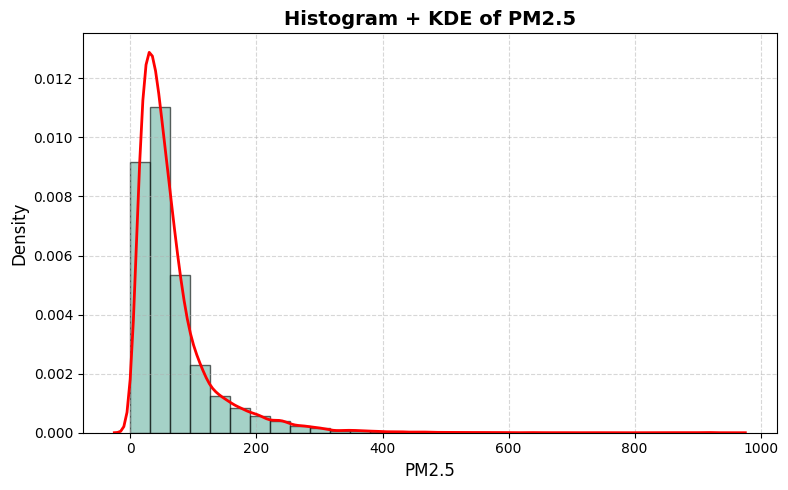

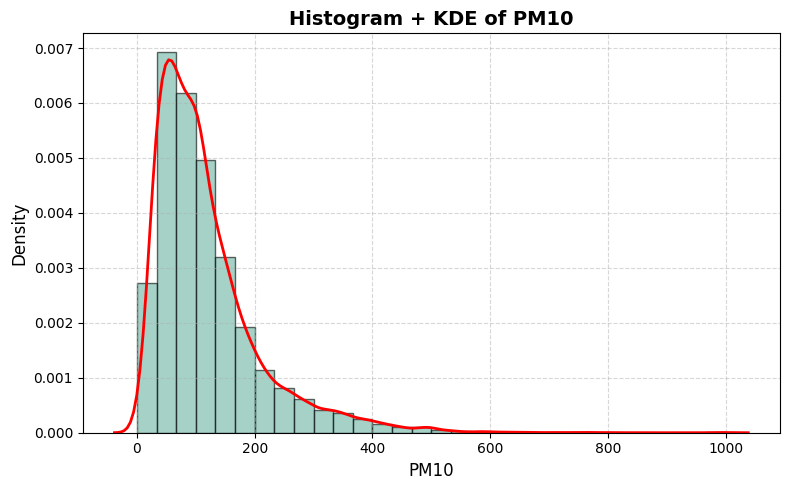

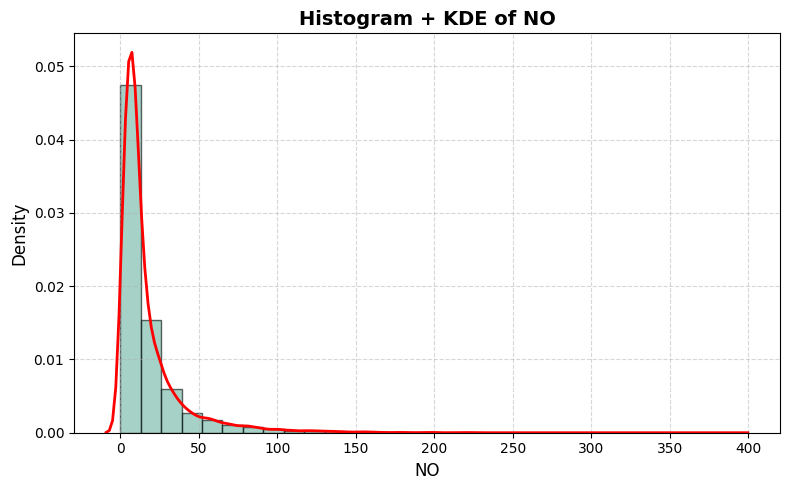

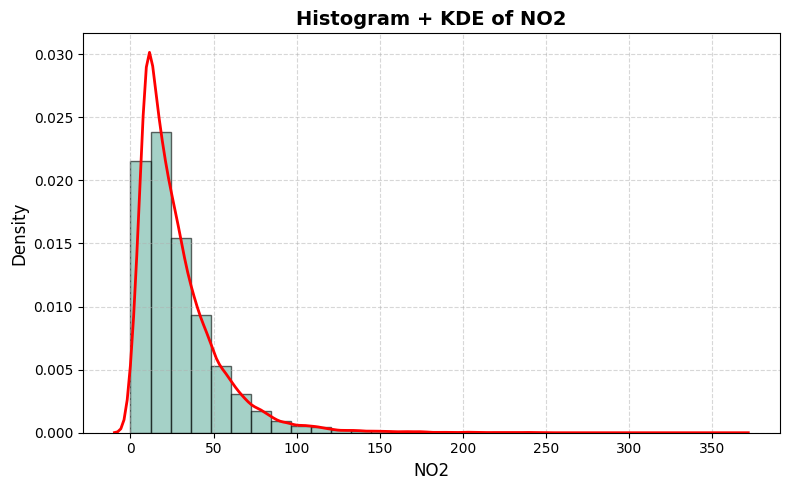

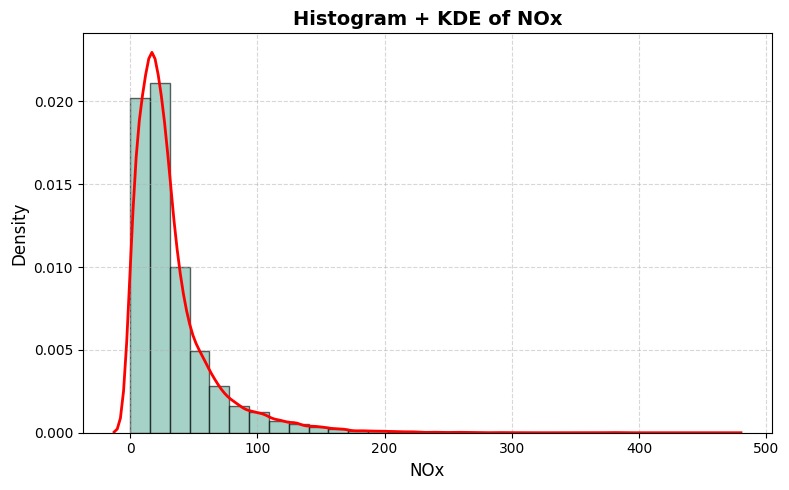

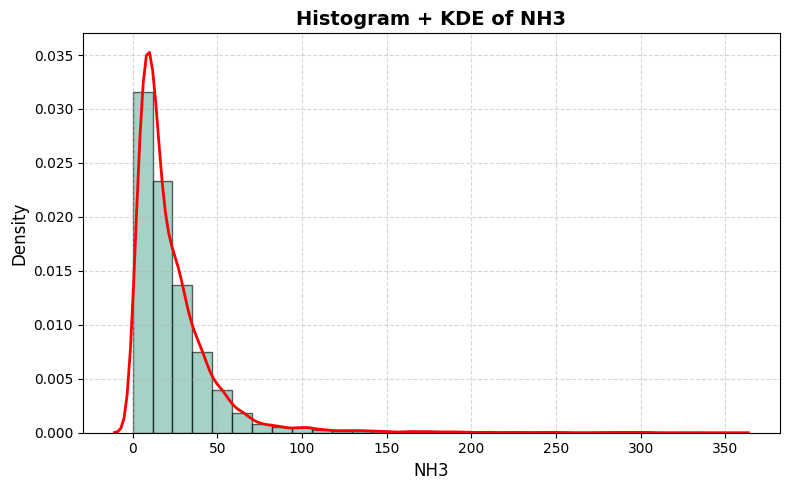

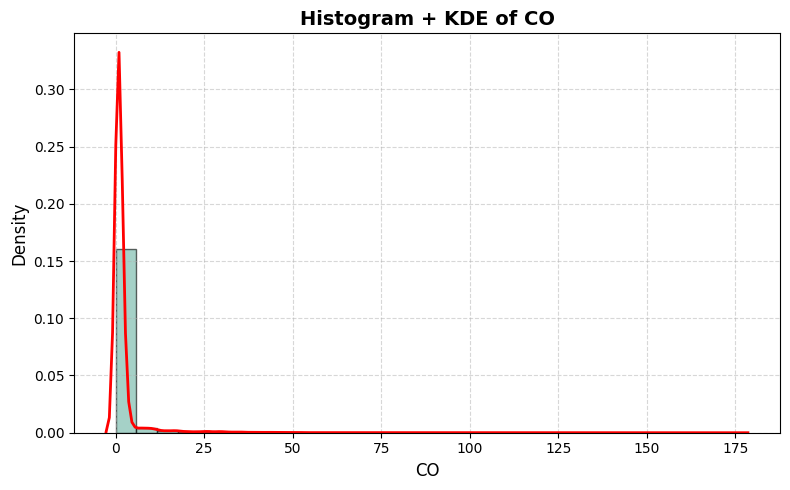

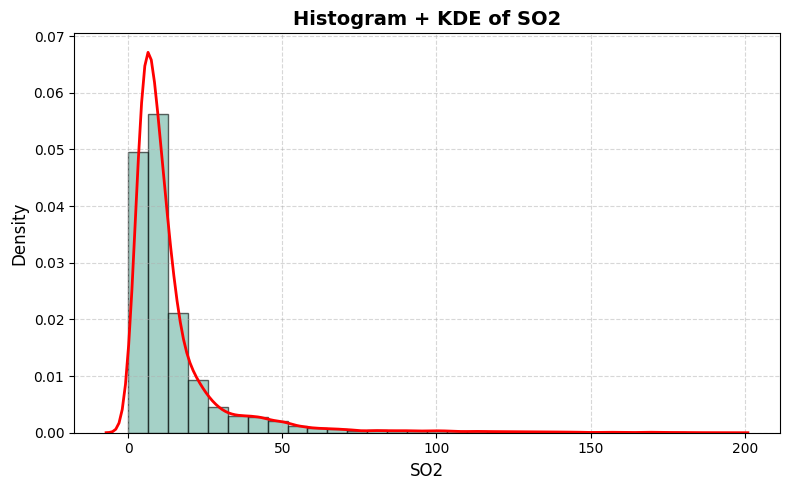

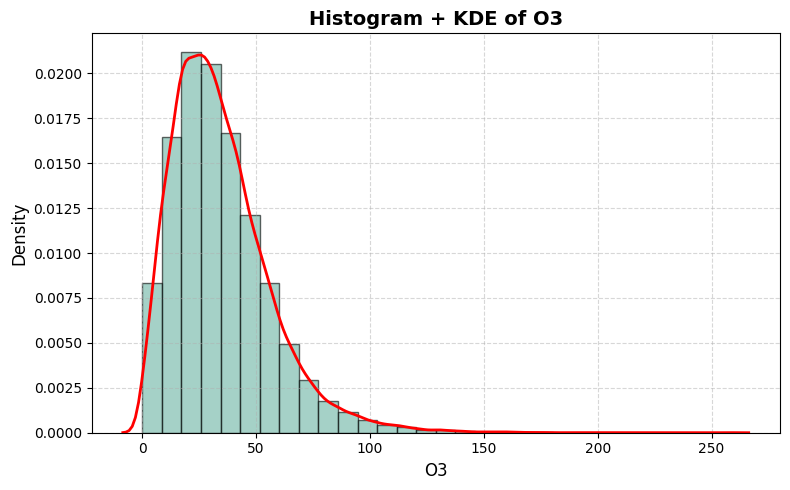

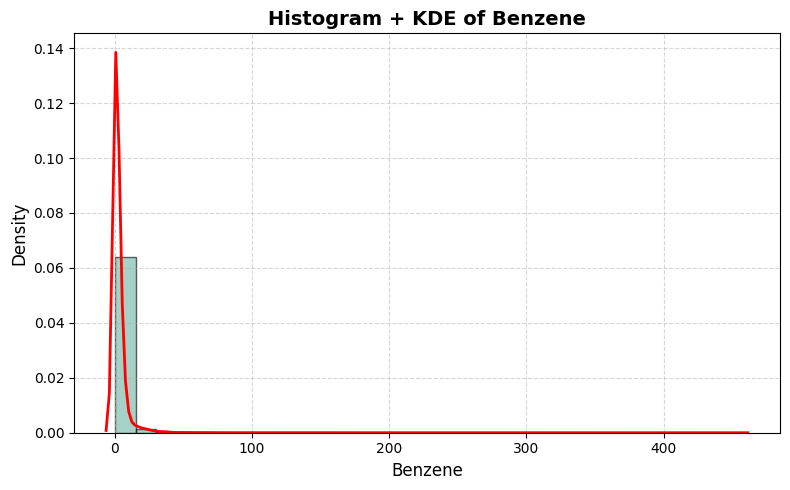

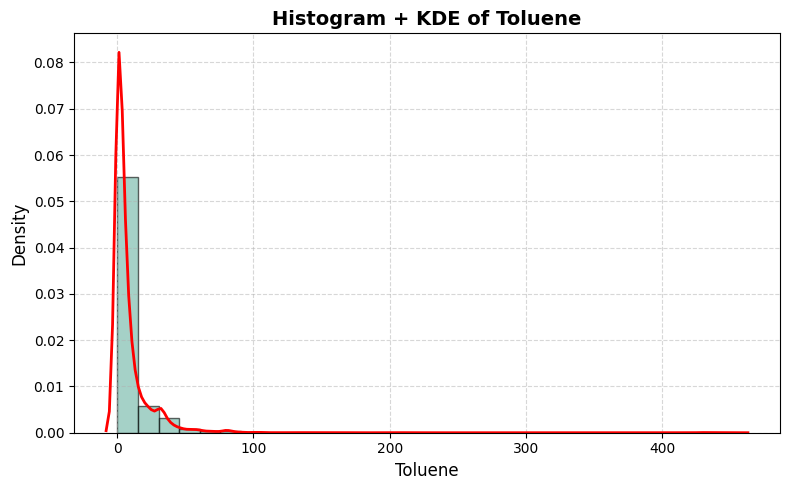

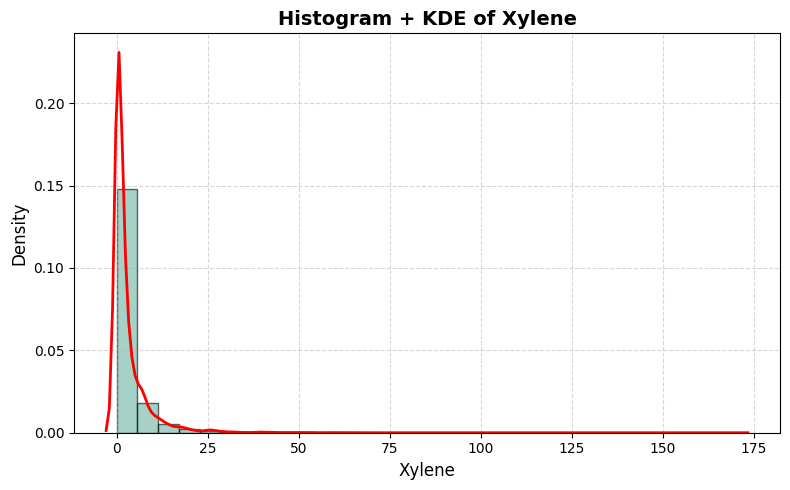

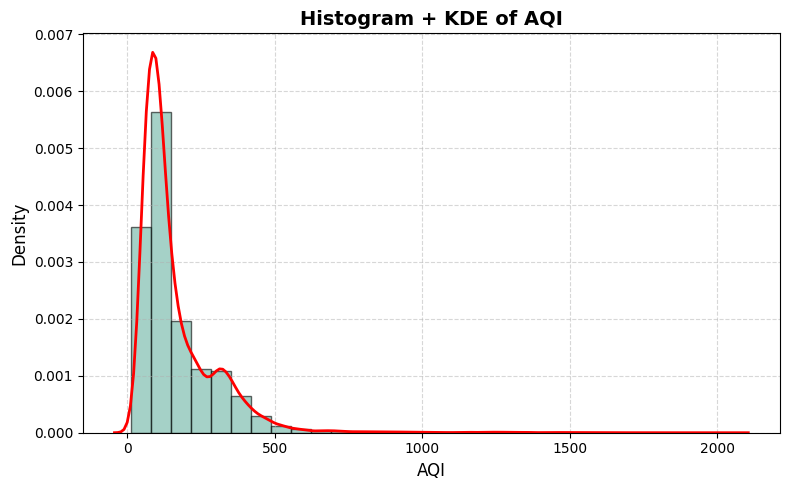

In [180]:
for col in numerical_cols:
    plt.figure(figsize=(8, 5))

    # Plot histogram (density=True scales it for KDE overlay)
    plt.hist(df[col].dropna(), bins=30, density=True,
             alpha=0.6, color='#69b3a2', edgecolor='black')

    # Overlay KDE plot
    sns.kdeplot(df[col].dropna(), color='red', linewidth=2, bw_adjust=1)

    # Titles and labels
    plt.title(f'Histogram + KDE of {col}', fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Density', fontsize=12)  # use Density, not Frequency, since scaled

    # Grid
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

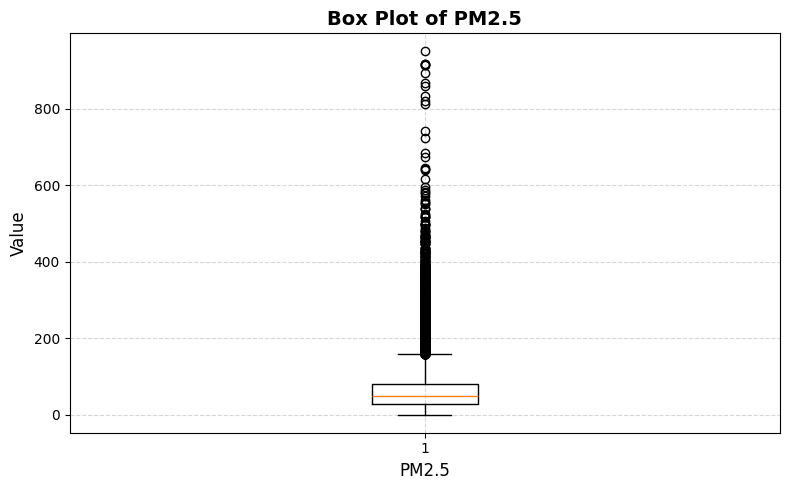

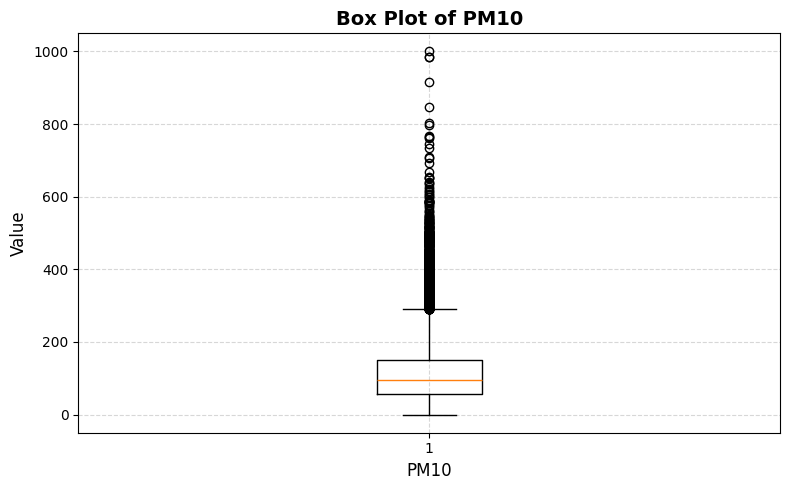

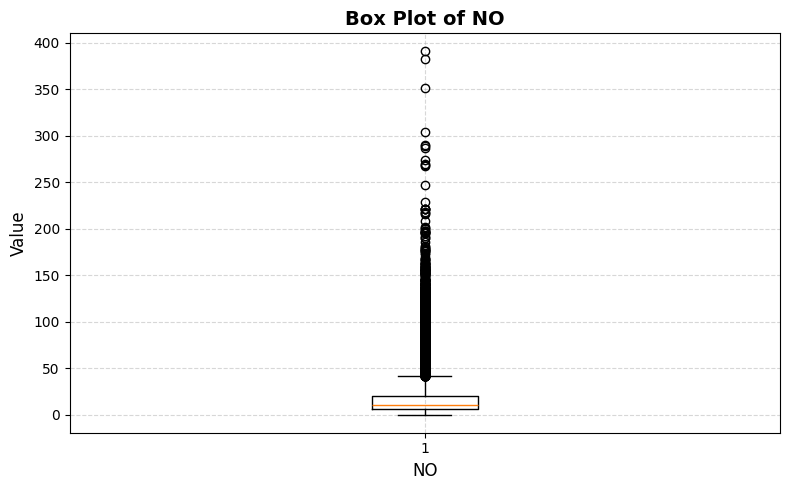

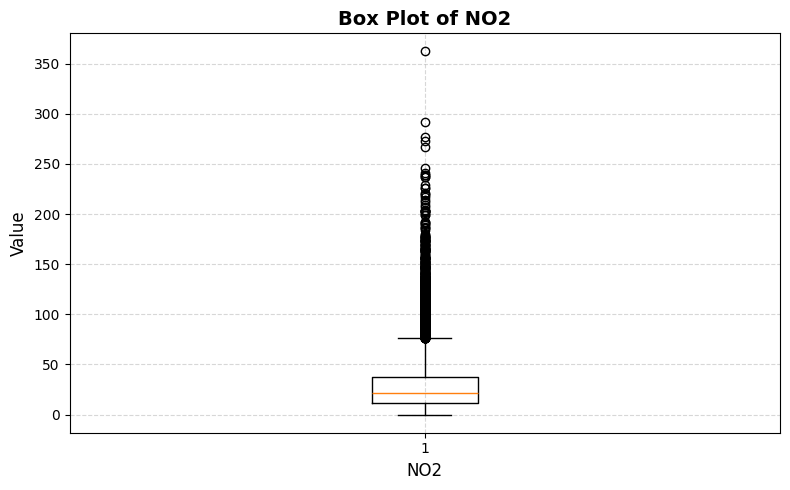

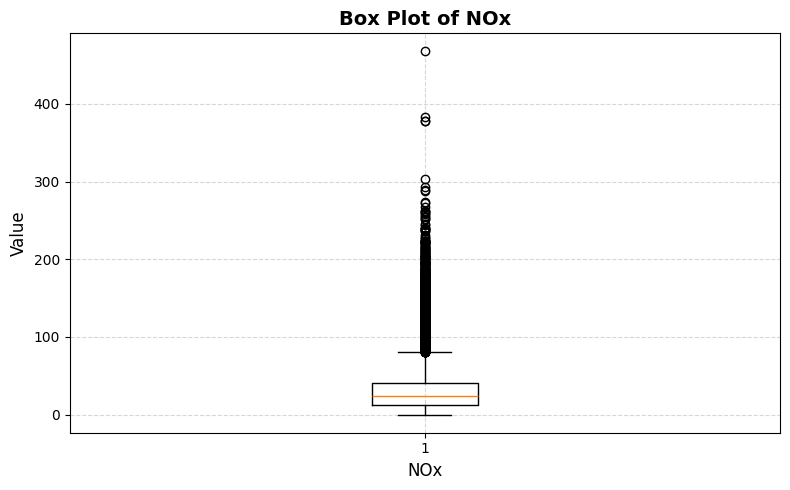

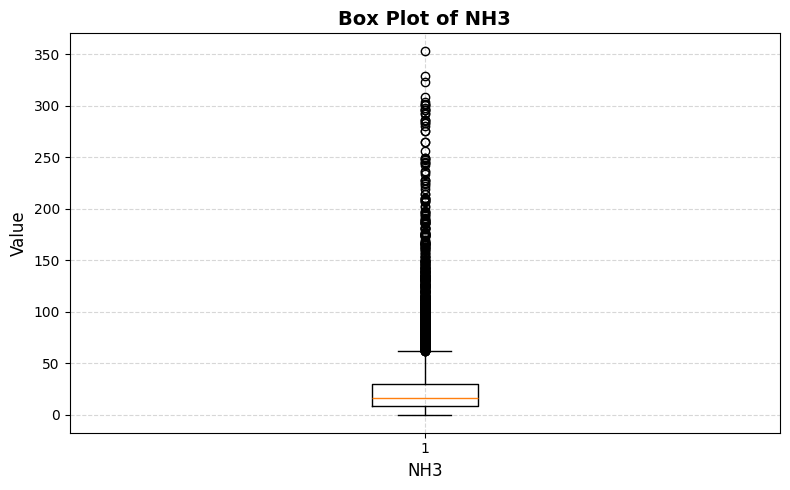

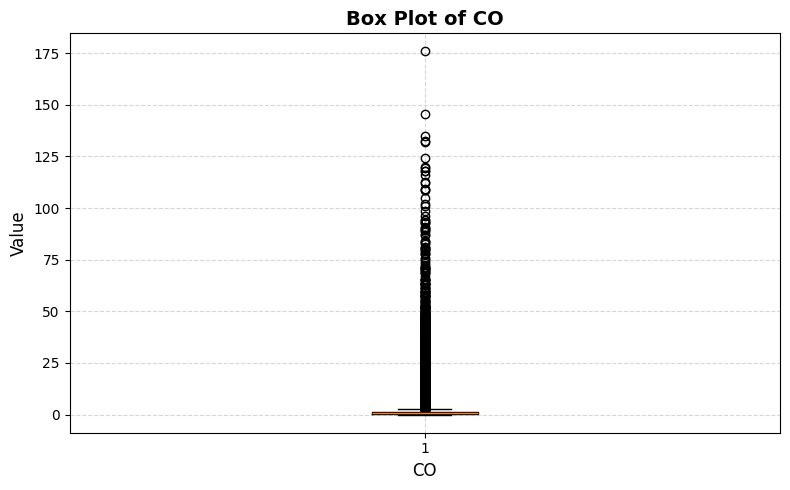

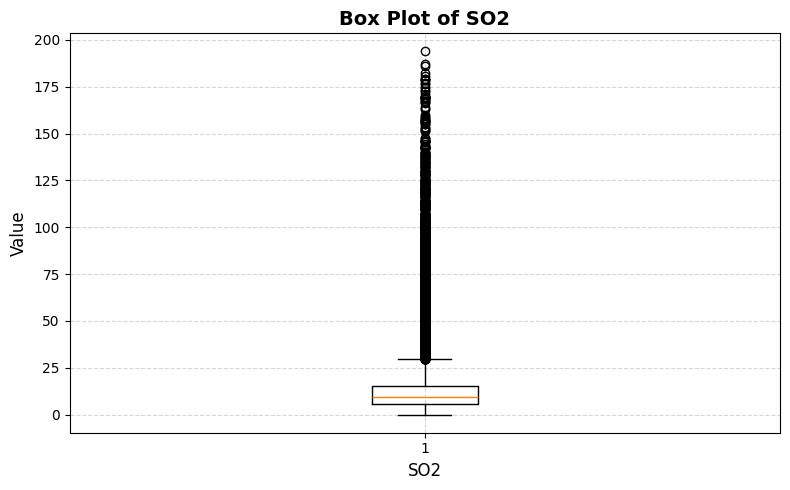

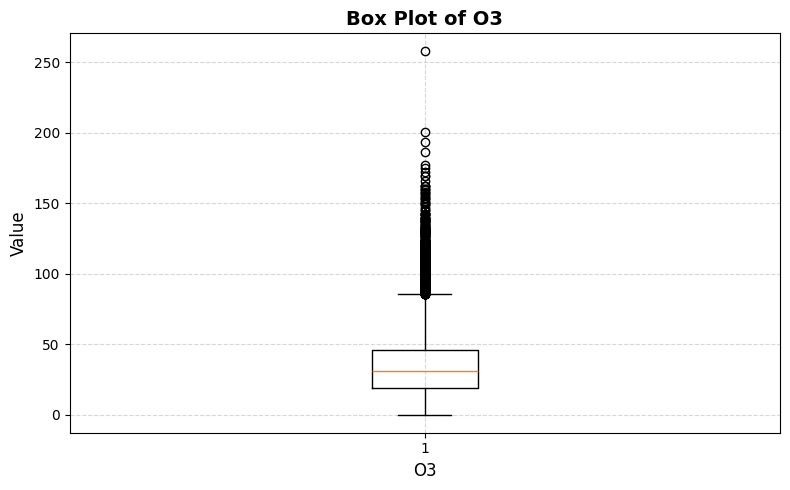

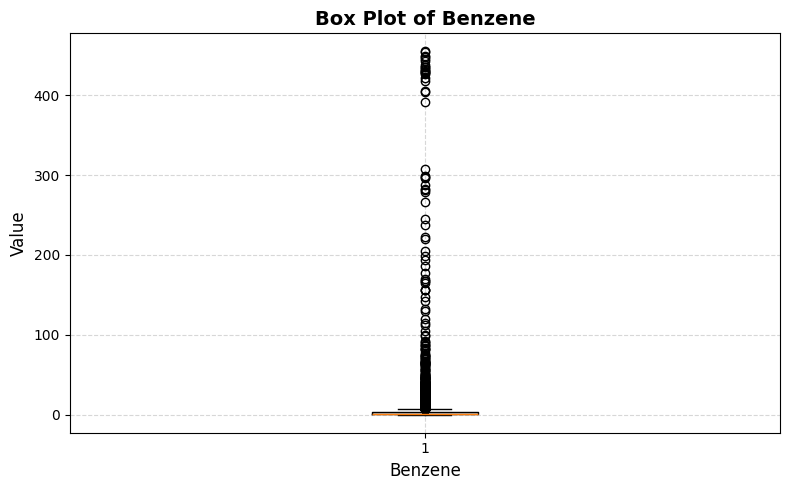

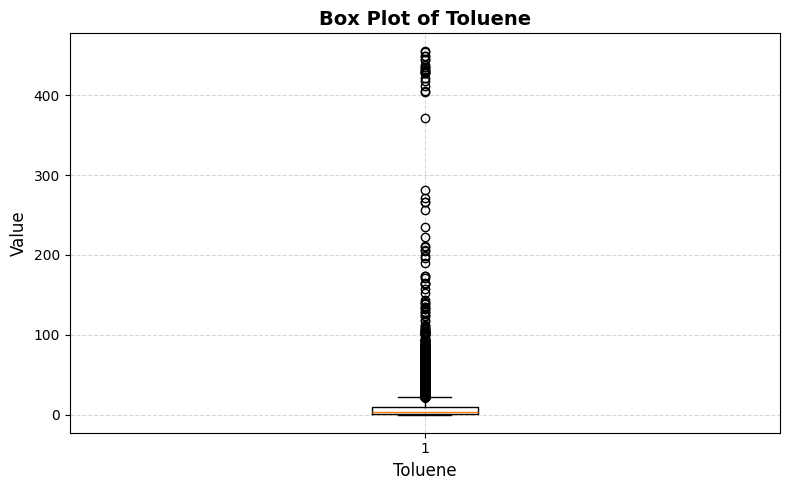

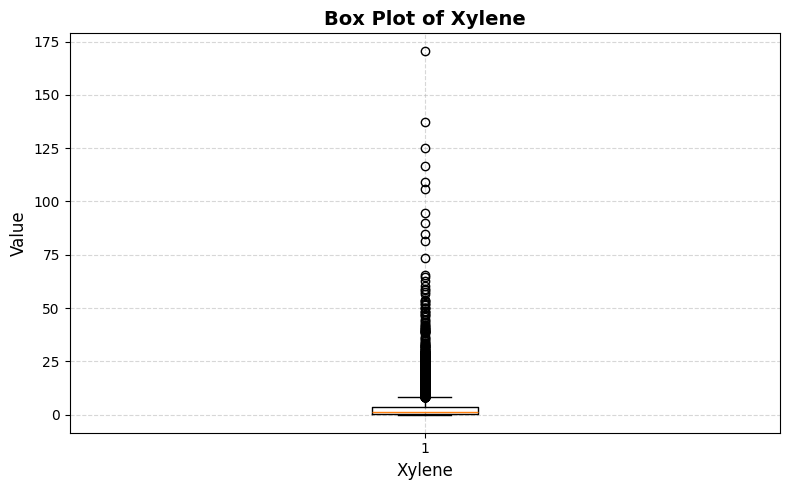

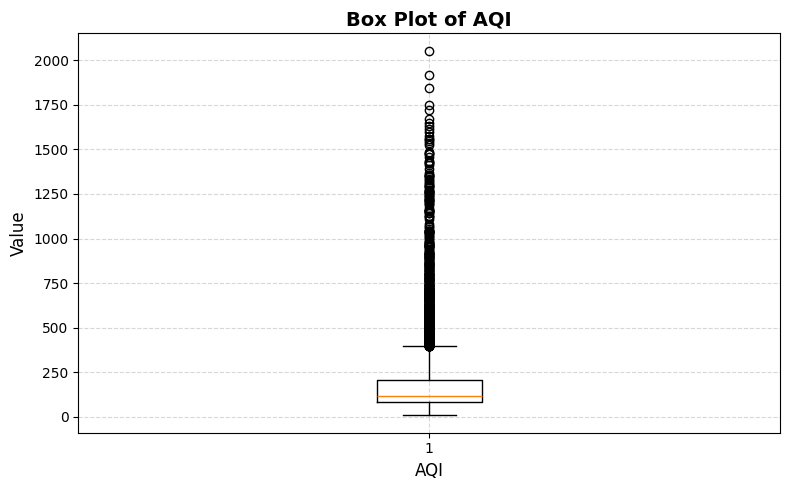

In [181]:
for col in numerical_cols:
    plt.figure(figsize=(8, 5))

    plt.boxplot(df[col].dropna())

    # Titles and labels
    plt.title(f'Box Plot of {col}', fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Value', fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


## Bivariate Analysis

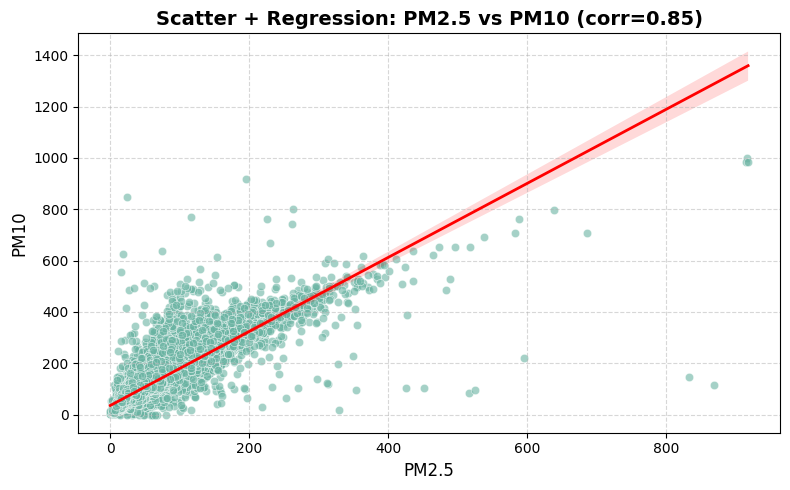

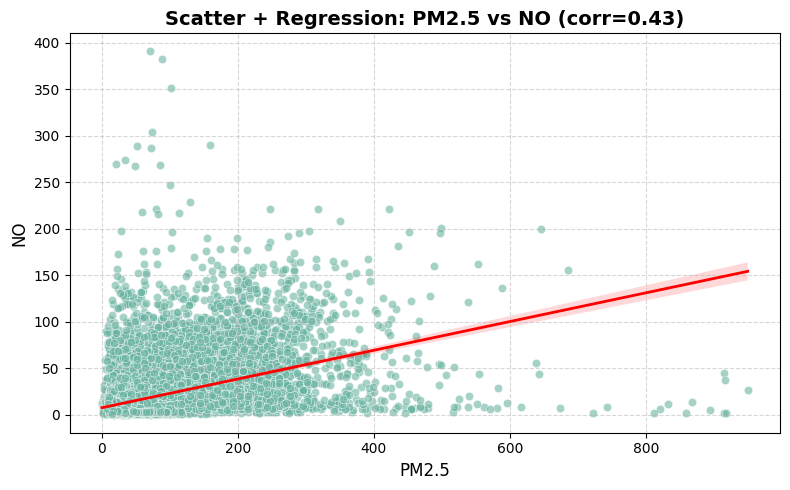

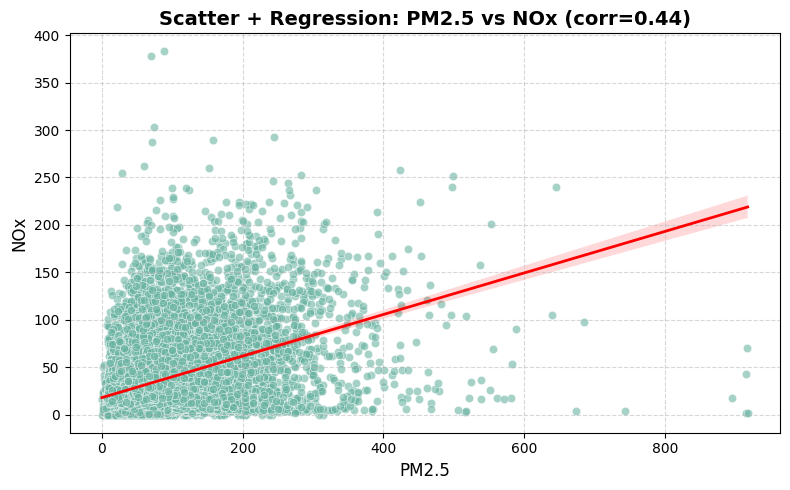

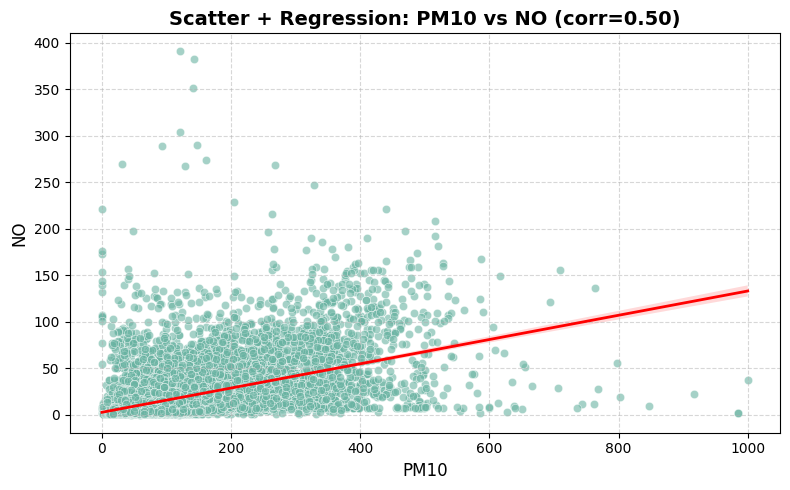

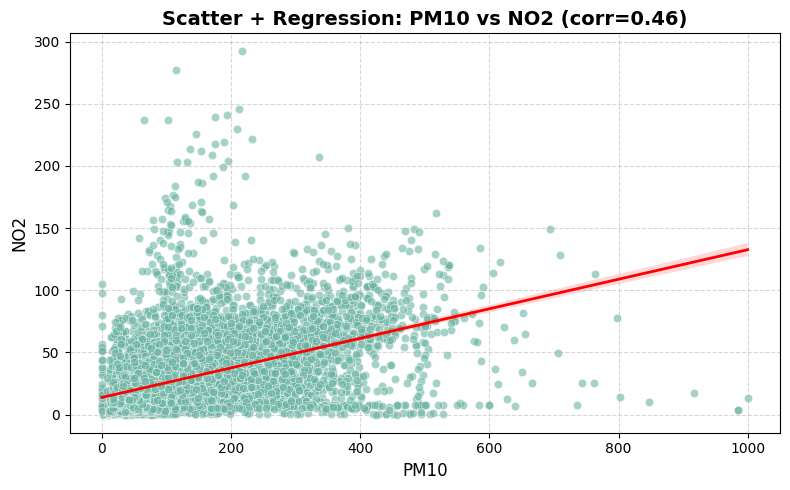

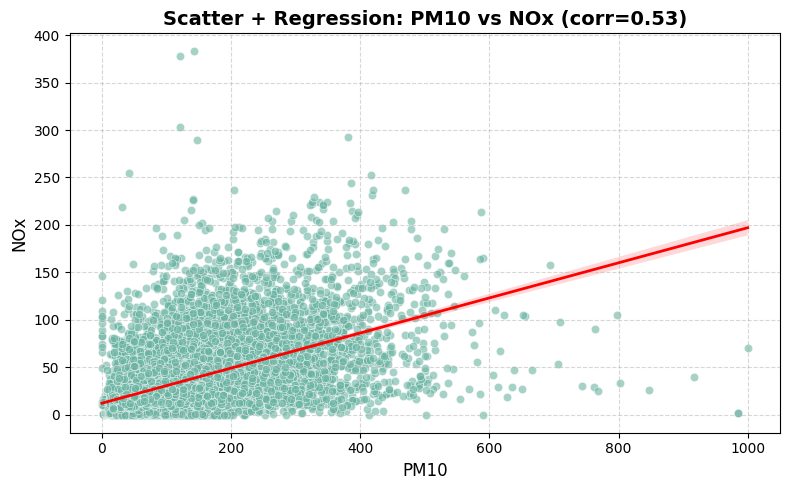

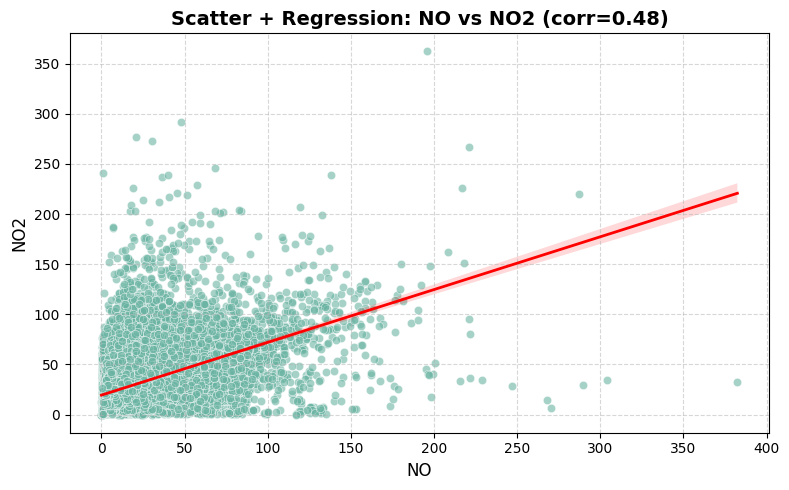

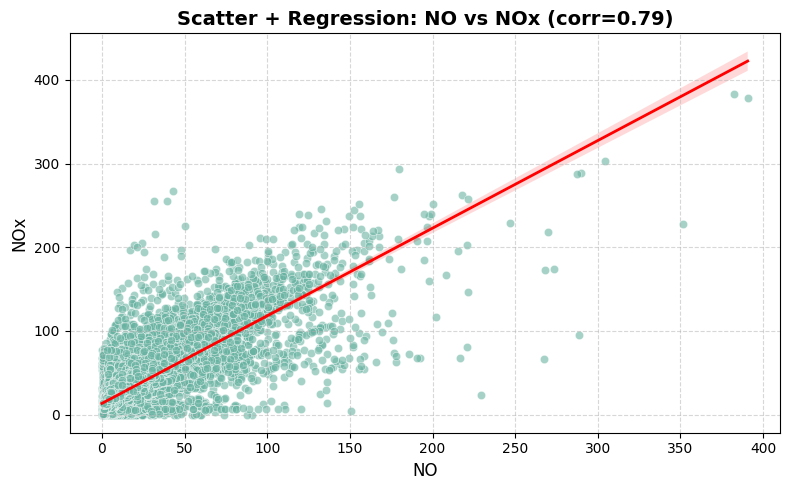

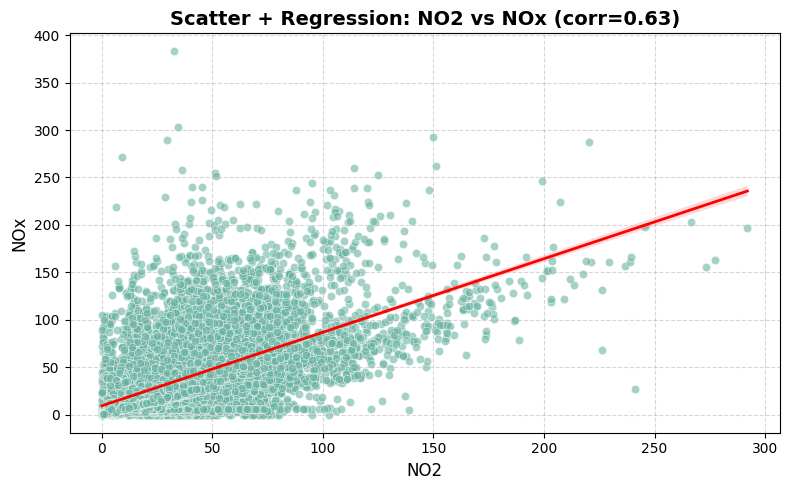

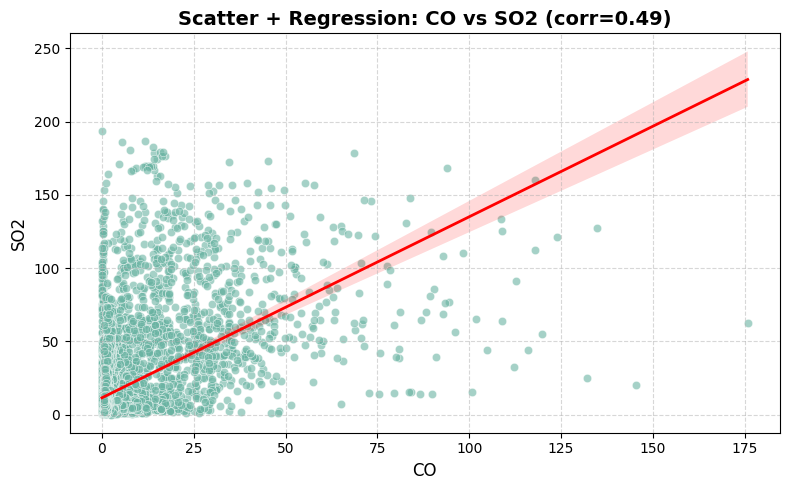

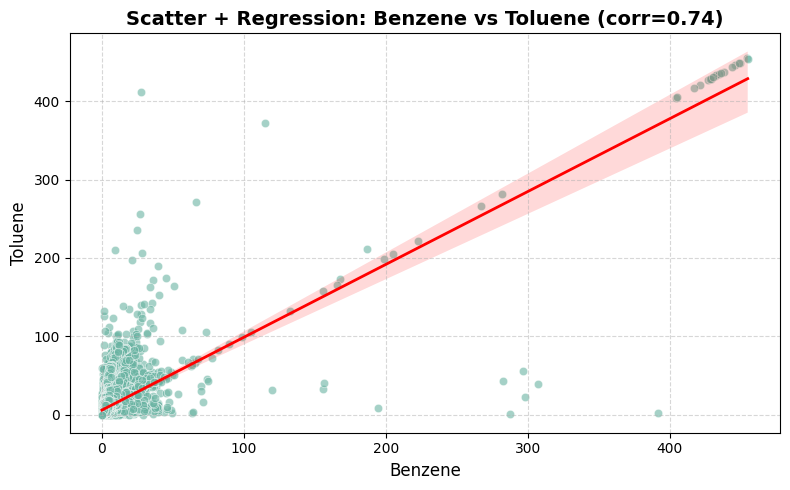

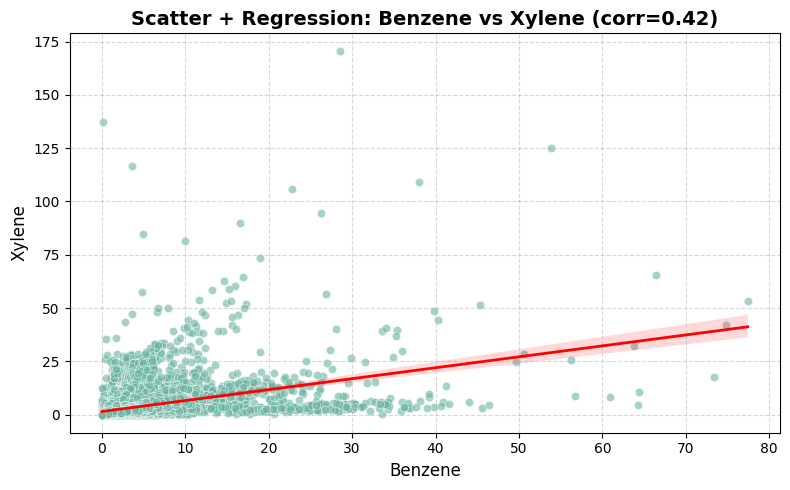

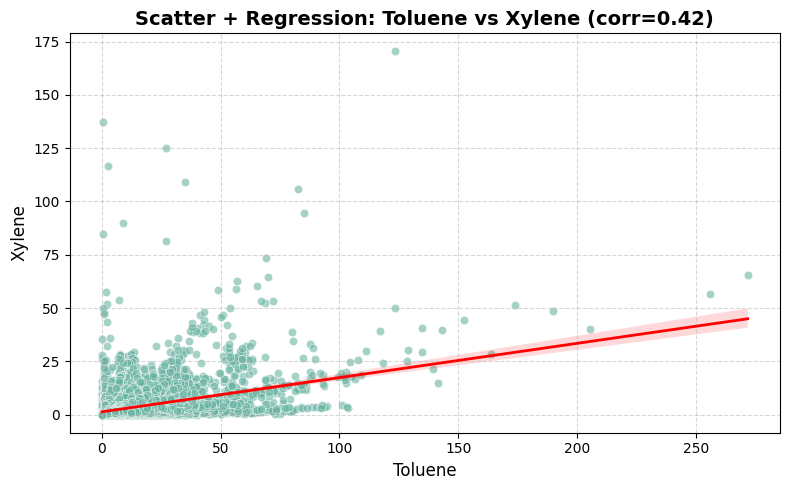

In [184]:
import itertools

corr_matrix = df[pollutants].corr()

# Threshold for “relatedness”
threshold = 0.4

pairs = list(itertools.combinations(pollutants, 2))

for x_col, y_col in pairs:
    corr_value = corr_matrix.loc[x_col, y_col]
    if abs(corr_value) >= threshold:  # only plot if correlated enough
        plt.figure(figsize=(8,5))
        sns.scatterplot(x=x_col, y=y_col, data=df, alpha=0.6, color='#69b3a2')
        sns.regplot(x=x_col, y=y_col, data=df, scatter=False, color='red', line_kws={'linewidth':2})
        plt.title(f'Scatter + Regression: {x_col} vs {y_col} (corr={corr_value:.2f})', fontsize=14, fontweight='bold')
        plt.xlabel(x_col, fontsize=12)
        plt.ylabel(y_col, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

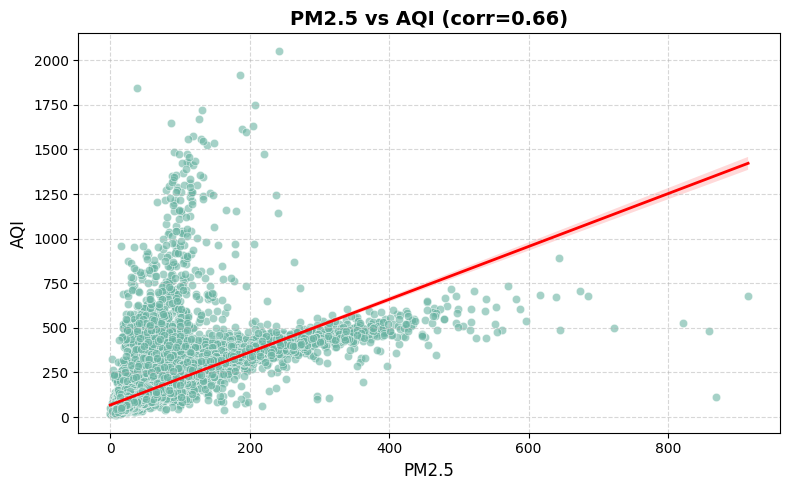

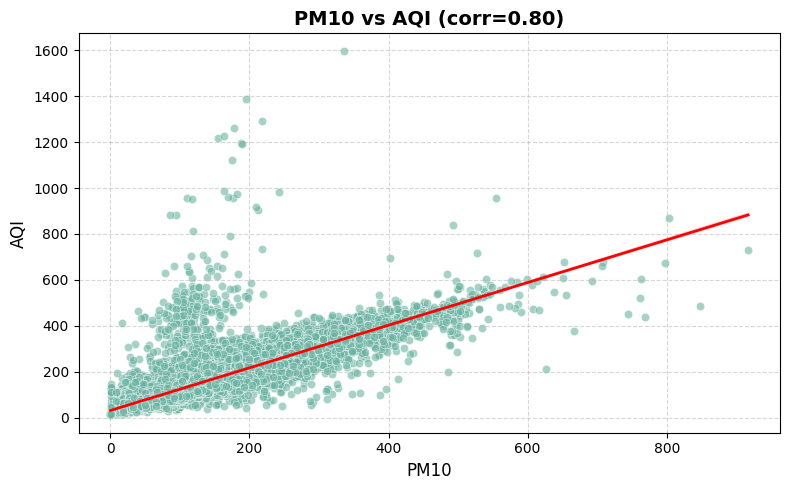

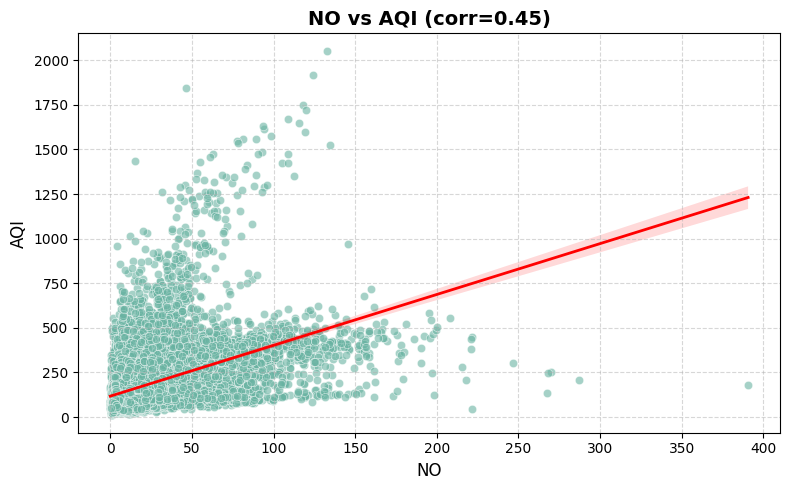

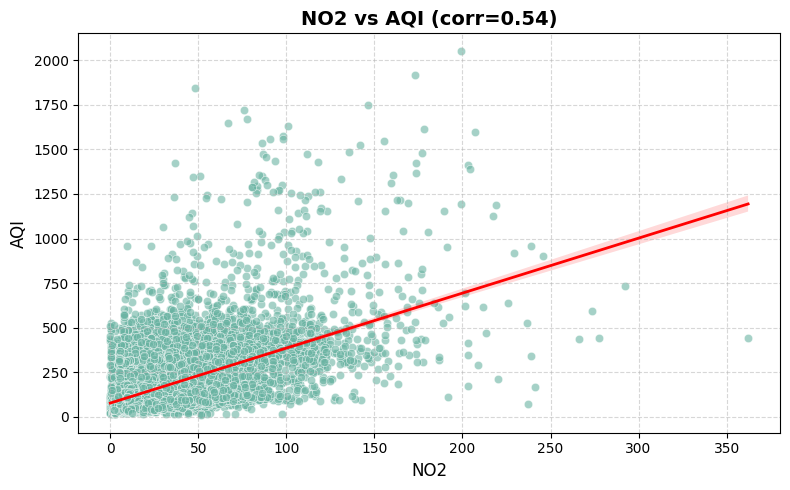

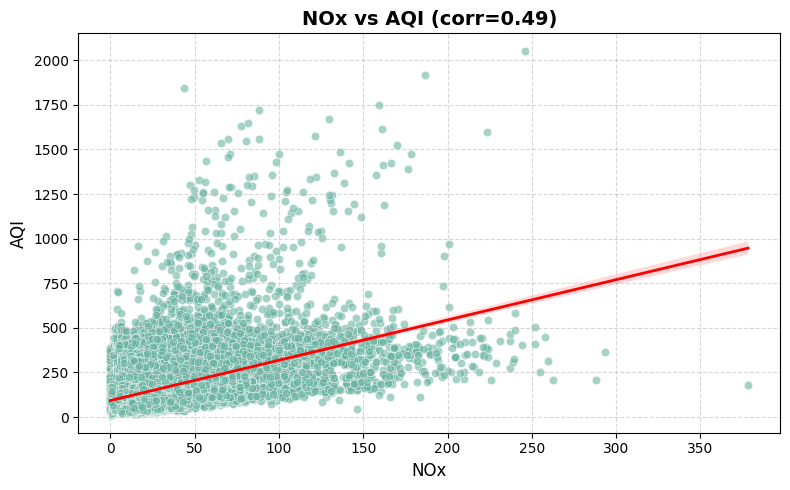

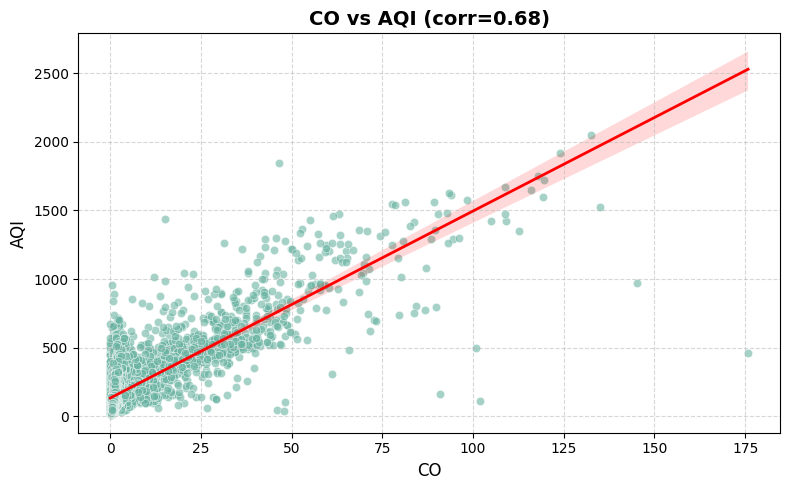

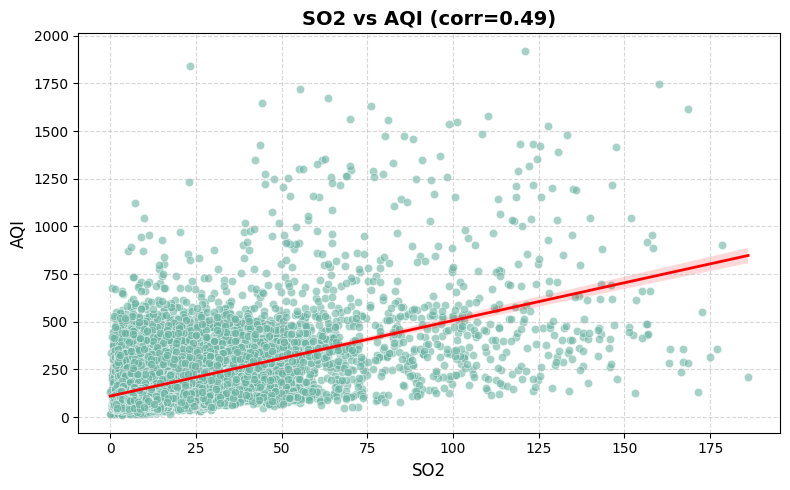

In [185]:
corr_with_aqi = df[pollutants + ['AQI']].corr()['AQI'].drop('AQI')

for col in pollutants:
    corr_value = corr_with_aqi[col]
    if abs(corr_value) >= threshold:
        plt.figure(figsize=(8,5))
        sns.scatterplot(x=col, y='AQI', data=df, alpha=0.6, color='#69b3a2')
        sns.regplot(x=col, y='AQI', data=df, scatter=False, color='red', line_kws={'linewidth':2})
        plt.title(f'{col} vs AQI (corr={corr_value:.2f})', fontsize=14, fontweight='bold')
        plt.xlabel(col, fontsize=12)
        plt.ylabel('AQI', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

## Multivariate Analysis

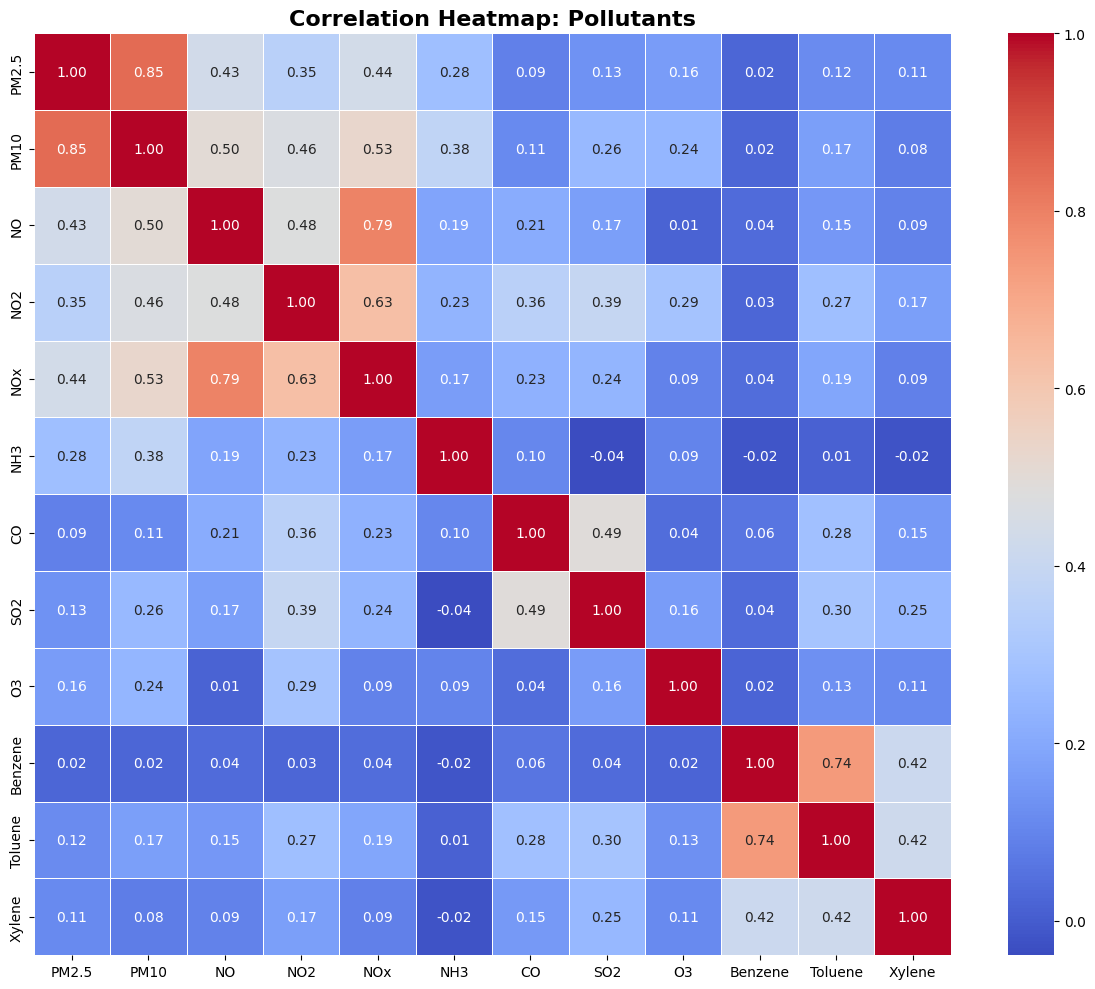

In [183]:
pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']

plt.figure(figsize=(12,10))
sns.heatmap(df[pollutants].corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap: Pollutants", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Train test split

In [188]:
numerical_cols = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']
target_col = 'AQI'

df = df.dropna(subset=['AQI'])
X = df[numerical_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Outlier Removal

In [189]:
def capping_outliers(X, cols):
    X = pd.DataFrame(X, columns=numerical_cols)
    for col in cols:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap values at lower and upper bounds
        X[col] = np.where(
            X[col] < lower_bound,
            lower_bound,

            np.where(
                X[col] > upper_bound,
                upper_bound,
                X[col]
            )
        )

    return X.values

In [190]:
# Wrap your function into a transformer
outlier_transformer = FunctionTransformer(capping_outliers, kw_args={'cols': numerical_cols})

# Linear Regerssion

In [191]:
numeric_transformer_lr = Pipeline(steps=[
    ('imputer', IterativeImputer()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler()),
])

In [192]:
preprocessor_lr = ColumnTransformer([
    ('num', numeric_transformer_lr, numerical_cols)
])

In [193]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),  # your ColumnTransformer pipeline
    ('regressor', Ridge())
])

In [194]:
param_grid_ridge = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 50, 100],
    'regressor__fit_intercept': [True, False]
}

grid = GridSearchCV(pipeline_lr, param_grid_ridge, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

In [198]:
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(best_model, X_train, y_train, cv=5, scoring=scoring)

print("Best hyperparameters found by GridSearchCV:")
print(grid.best_params_)

# Convert negatives to positive for MAE and MSE
mae_mean = -cv_results['test_mae'].mean()
mse_mean = -cv_results['test_mse'].mean()
rmse_mean = np.sqrt(mse_mean)
r2_mean = cv_results['test_r2'].mean()

print(f"Mean R²: {r2_mean:.4f}")
print(f"Mean MAE: {mae_mean:.4f}")
print(f"Mean RMSE: {rmse_mean:.4f}")

Best hyperparameters found by GridSearchCV:
{'regressor__alpha': 10, 'regressor__fit_intercept': True}
Mean R²: 0.8793
Mean MAE: 26.9421
Mean RMSE: 49.2790


# Decision Tree

In [199]:
numeric_transformer_dt = Pipeline(steps=[
    ('imputer', IterativeImputer()),
])

In [200]:
preprocessor_dt = ColumnTransformer([
    ('num', numeric_transformer_dt, numerical_cols)
])

In [201]:
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor_dt),  # your ColumnTransformer pipeline
    ('regressor', DecisionTreeRegressor(random_state=42))
])

In [202]:
param_grid_dt = {
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 5],
    'regressor__max_features': [None, 'sqrt', 'log2']
}

In [203]:
grid_dt = GridSearchCV(
    pipeline_dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [204]:
grid_dt.fit(X_train, y_train)

print("Best parameters:", grid_dt.best_params_)

best_dt = grid_dt.best_estimator_

Best parameters: {'regressor__max_depth': 10, 'regressor__max_features': None, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 2}


In [205]:
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(best_dt, X_train, y_train, cv=5, scoring=scoring)

# Convert negative MAE and MSE to positive
mae_mean = -cv_results['test_mae'].mean()
mse_mean = -cv_results['test_mse'].mean()
rmse_mean = np.sqrt(mse_mean)
r2_mean = cv_results['test_r2'].mean()

# Print nicely
print(f"Cross-validated Metrics (5-fold):")
print(f"R²   : {r2_mean:.4f}")
print(f"MAE  : {mae_mean:.4f}")
print(f"MSE  : {mse_mean:.4f}")
print(f"RMSE : {rmse_mean:.4f}")

Cross-validated Metrics (5-fold):
R²   : 0.8729
MAE  : 25.2772
MSE  : 2562.4699
RMSE : 50.6208


# Random Forest

In [206]:
numeric_transformer_rf = Pipeline(steps=[
    ('imputer', IterativeImputer()),
])

In [207]:
preprocessor_rf = ColumnTransformer([
    ('num', numeric_transformer_rf, numerical_cols)
])

In [208]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),  # your ColumnTransformer pipeline
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [209]:
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error'
}

# Cross-validation
cv_results = cross_validate(pipeline_rf, X_train, y_train, cv=5, scoring=scoring)

# Convert negatives
mae_mean = -cv_results['test_mae'].mean()
mse_mean = -cv_results['test_mse'].mean()
rmse_mean = np.sqrt(mse_mean)
r2_mean = cv_results['test_r2'].mean()

# Print nicely
print(f"Random Forest CV Metrics (5-fold):")
print(f"R²   : {r2_mean:.4f}")
print(f"MAE  : {mae_mean:.4f}")
print(f"MSE  : {mse_mean:.4f}")
print(f"RMSE : {rmse_mean:.4f}")

Random Forest CV Metrics (5-fold):
R²   : 0.9023
MAE  : 21.6156
MSE  : 1967.4469
RMSE : 44.3559


# K Nearest Neighboors

In [210]:
numeric_transformer_knn = Pipeline(steps=[
    ('imputer', IterativeImputer()),
    ('cap_outliers', outlier_transformer),
    ('scaler', StandardScaler()),
])

In [211]:
preprocessor_knn = ColumnTransformer([
    ('num', numeric_transformer_knn, numerical_cols)
])

In [212]:
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor_knn),  # your ColumnTransformer pipeline
    ('regressor', KNeighborsRegressor(n_neighbors=5))
])

In [213]:
param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7 , 10 , 15],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__p': [1, 2]  # Manhattan (1) or Euclidean (2)
}

In [214]:
grid_knn = GridSearchCV(
    pipeline_knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [215]:
grid_knn.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters:", grid_knn.best_params_)

# Cross-validated R² using best estimator
best_knn = grid_knn.best_estimator_

Best parameters: {'regressor__n_neighbors': 7, 'regressor__p': 2, 'regressor__weights': 'distance'}


In [216]:
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(best_knn, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)

r2_mean = cv_results['test_r2'].mean()
mae_mean = -cv_results['test_mae'].mean()
mse_mean = -cv_results['test_mse'].mean()
rmse_mean = np.sqrt(mse_mean)

print(f"KNN CV Metrics (5-fold):")
print(f"R²   : {r2_mean:.4f}")
print(f"MAE  : {mae_mean:.4f}")
print(f"MSE  : {mse_mean:.4f}")
print(f"RMSE : {rmse_mean:.4f}")

KNN CV Metrics (5-fold):
R²   : 0.8809
MAE  : 23.8846
MSE  : 2401.6280
RMSE : 49.0064


# XGBoost

In [ ]:
numeric_transformer_xgb = Pipeline(steps=[
    ('imputer', IterativeImputer()),
])

In [218]:
preprocessor_xgb = ColumnTransformer([
    ('num', numeric_transformer_xgb, numerical_cols)
])

In [219]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_xgb),  # your ColumnTransformer pipeline
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

In [220]:
param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5],
    'regressor__learning_rate': [0.01, 0.05],
    'regressor__subsample': [0.6, 0.8],
    'regressor__colsample_bytree': [0.6, 0.8],
    'regressor__min_child_weight': [1, 3]
}

In [221]:
grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [222]:
grid_xgb.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters:", grid_xgb.best_params_)

# Cross-validated R² using best estimator
best_xgb = grid_xgb.best_estimator_

Best parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 200, 'regressor__subsample': 0.6}


In [223]:
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(best_xgb , X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)

r2_mean = cv_results['test_r2'].mean()
mae_mean = -cv_results['test_mae'].mean()
mse_mean = -cv_results['test_mse'].mean()
rmse_mean = np.sqrt(mse_mean)

print(f"KNN CV Metrics (5-fold):")
print(f"R²   : {r2_mean:.4f}")
print(f"MAE  : {mae_mean:.4f}")
print(f"MSE  : {mse_mean:.4f}")
print(f"RMSE : {rmse_mean:.4f}")

KNN CV Metrics (5-fold):
R²   : 0.9033
MAE  : 22.3770
MSE  : 1945.7498
RMSE : 44.1107


# ANN

In [224]:
numeric_transformer_ann = Pipeline(steps=[
    ('imputer', IterativeImputer()),
    ('cap_outliers', outlier_transformer),
    ('power', PowerTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

In [225]:
preprocessor_ann = ColumnTransformer([
    ('num', numeric_transformer_ann, numerical_cols)
])

In [226]:
pipeline_ann = Pipeline(steps=[
    ('preprocessor', preprocessor_ann),  # your ColumnTransformer pipeline
    ('ann', MLPRegressor(hidden_layer_sizes=(64, 32),  # 2 hidden layers
                         activation='relu',           # common for regression
                         solver='adam',              # optimizer
                         learning_rate_init=0.001,
                         max_iter=5000,
                         random_state=42))
])

In [227]:
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(pipeline_ann, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)

r2_mean = cv_results['test_r2'].mean()
mae_mean = -cv_results['test_mae'].mean()
mse_mean = -cv_results['test_mse'].mean()
rmse_mean = np.sqrt(mse_mean)

print(f"ANN CV Metrics (5-fold):")
print(f"R²   : {r2_mean:.4f}")
print(f"MAE  : {mae_mean:.4f}")
print(f"MSE  : {mse_mean:.4f}")
print(f"RMSE : {rmse_mean:.4f}")

ANN CV Metrics (5-fold):
R²   : 0.8679
MAE  : 25.8939
MSE  : 2664.8223
RMSE : 51.6219


# Exporting Model as pkl file

In [231]:
joblib.dump(best_xgb , "best_model.pkl")
print("Model saved as best_model.pkl")

Model saved as best_model.pkl


In [234]:
# Load the saved model
loaded_model = joblib.load("best_model.pkl")

# Predict on test data
y_pred = loaded_model.predict(X_test)

In [235]:
# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print results
print("Metrics on Loaded Model:")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")


Metrics on Loaded Model:
R²   : 0.8933
MAE  : 22.7878
MSE  : 1954.5112
RMSE : 44.2099
